# [금융] 보험료 예측

## data 준비

### mount setting

In [ ]:
# mount
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab/study/dataset

Mounted at /content/drive
/content/drive/MyDrive/Colab/study/dataset


### library setting

In [ ]:
#library

import pandas as pd
import numpy as np
import seaborn as sns
import missingno

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score

### data load

In [ ]:
#data load

data = pd.read_csv('/content/drive/MyDrive/Colab/study/dataset/ch3_premium.csv') 

In [ ]:
# data shape
print(data.shape)

(1338, 7)


In [ ]:
print(data.head(15))

    age     sex     bmi  children smoker     region      charges
0    19  female  27.900         0    yes  southwest  16884.92400
1    18    male  33.770         1     no  southeast   1725.55230
2    28    male  33.000         3     no  southeast   4449.46200
3    33    male  22.705         0     no  northwest  21984.47061
4    32    male  28.880         0     no  northwest   3866.85520
5    31  female  25.740         0     no  southeast   3756.62160
6    46  female  33.440         1     no  southeast   8240.58960
7    37  female  27.740         3     no  northwest   7281.50560
8    37    male  29.830         2     no  northeast   6406.41070
9    60  female  25.840         0     no  northwest  28923.13692
10   25    male  26.220         0     no  northeast   2721.32080
11   62  female  26.290         0    yes  southeast  27808.72510
12   23    male  34.400         0     no  southwest   1826.84300
13   56  female  39.820         0     no  southeast  11090.71780
14   27    male     NaN  

## data EDA

In [ ]:
#중복된 항목수 알아보기
print("중복된 항목 수: ", len(data[data.duplicated()]))

중복된 항목 수:  1


In [ ]:
# 중복된 항목 확인하기
print(data[data.duplicated(keep=False)].sort_values(by=list(data.columns)).head(15))

     age   sex    bmi  children smoker     region    charges
195   19  male  30.59         0     no  northwest  1639.5631
581   19  male  30.59         0     no  northwest  1639.5631


In [ ]:
# 중복된 항목 제거
data.drop_duplicates(inplace=True, keep="first", ignore_index=True)

In [ ]:
data.shape

(1337, 7)

In [ ]:
# 데이터 컬럼 이름, 타입 정보 확인
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1332 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.2+ KB
None


In [ ]:
# 데이터 타입별 컬럼 수 확인하기
dtype_data = data.dtypes.reset_index()
dtype_data.columns = ['count', 'column Type']
dtype_data  = dtype_data.groupby('column Type').aggregate('count').reset_index()
dtype_data

,column Type,count
0,int64,2
1,float64,2
2,object,3


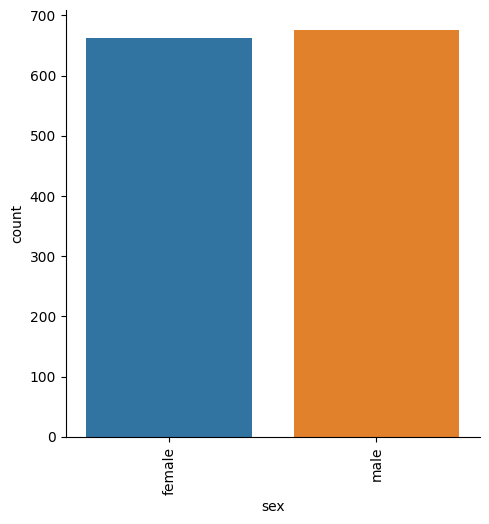

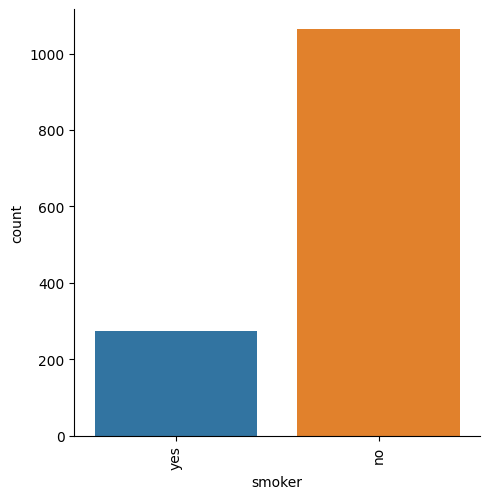

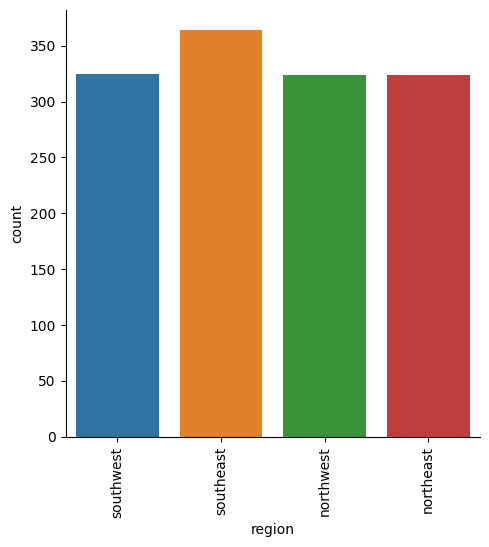

In [ ]:
# 범주형 변수별 개수 시각화
for col in data.select_dtypes(include=['object', 'category']).columns:
    fig = sns.catplot(x=col, kind='count', data=data, hue=None)
    fig.set_xticklabels(rotation=90)
    plt.show()


In [ ]:
#데이터 컬럼별 유일한 값  개수 확인하기
print(data.select_dtypes(include=['object', 'category']).nunique())

sex       2
smoker    2
region    4
dtype: int64


### 범주형 변수 변환
sklearn 의 LabelEncoder, OneHotEncoder 사용

항목이 2개인 성별과, 흡연 여부는 LabelEncoder 를, 지역은 OneHotEncoder 를 사용하기로 한다.

In [ ]:
## LabelEncoder : 각각의 범주를 서로 다른 정수로 맵핑
## 성별, 흡연 여부 컬럼은 Label Encoding 을 위해 ndarray 로 변환하여 준다
sex = data.iloc[:,1:2].values

### 성별 ###
# 1. LabelEncoder() 를 선언해주고
le = LabelEncoder()


# 2. 성별을 LabelEncoder 의 fit_transform 에 넣어준다
sex[:, 0] = le.fit_transform(sex[:, 0])
sex = pd.DataFrame(sex)
sex.columns = ['sex']

# 3. dict 형으로 변환해주기
le_sex_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("성별에 대한 Label Encoder 결과 : ")
print(le_sex_mapping)
print(sex[:10])


성별에 대한 Label Encoder 결과 : 
{'female': 0, 'male': 1}
  sex
0   0
1   1
2   1
3   1
4   1
5   0
6   0
7   0
8   1
9   0


In [ ]:
### 흡연 여부 ###
smoker = data.iloc[:,4:5].values

# 1. LabelEncoder() 를 선언해주고
le = LabelEncoder()

# 2. 흡연 여부를 LabelEncoder 의 fit_transform 에 넣어준다
smoker[:, 0] = le.fit_transform(smoker[:, 0])
smoker = pd.DataFrame(smoker)
smoker.columns = ['smoker']

# 3. dict 형으로 변환해주기
le_smoker_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("흡연에 대한 Label Encoder 결과 : ")
print(le_smoker_mapping)
print(smoker[:10])

흡연에 대한 Label Encoder 결과 : 
{'no': 0, 'yes': 1}
  smoker
0      1
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0


In [ ]:
## OneHot Encoder : 각각의 범주를 0과 1로 맵핑
## 지역 컬럼은 Label Encoding 을 위해 ndarray 로 변환하여 준다
region = data.iloc[:,5:6].values

### 지역 ###
# 1. OneHotEncoder() 를 선언해주고
ohe = OneHotEncoder()

# 2. 지역을 OneHotEncoder 의 fit_transform 에 넣어준다
region = ohe.fit_transform(region).toarray()
region = pd.DataFrame(region)
region.columns = ['northeast', 'northwest', 'southeast', 'southwest']
print("지역에 대한 OneHot Encoder 결과 : ")  
print(region[:10])

지역에 대한 OneHot Encoder 결과 : 
   northeast  northwest  southeast  southwest
0        0.0        0.0        0.0        1.0
1        0.0        0.0        1.0        0.0
2        0.0        0.0        1.0        0.0
3        0.0        1.0        0.0        0.0
4        0.0        1.0        0.0        0.0
5        0.0        0.0        1.0        0.0
6        0.0        0.0        1.0        0.0
7        0.0        1.0        0.0        0.0
8        1.0        0.0        0.0        0.0
9        0.0        1.0        0.0        0.0


### 결측치 확인 및 채우기(filna)

bmi    5
dtype: int64


<Axes: >

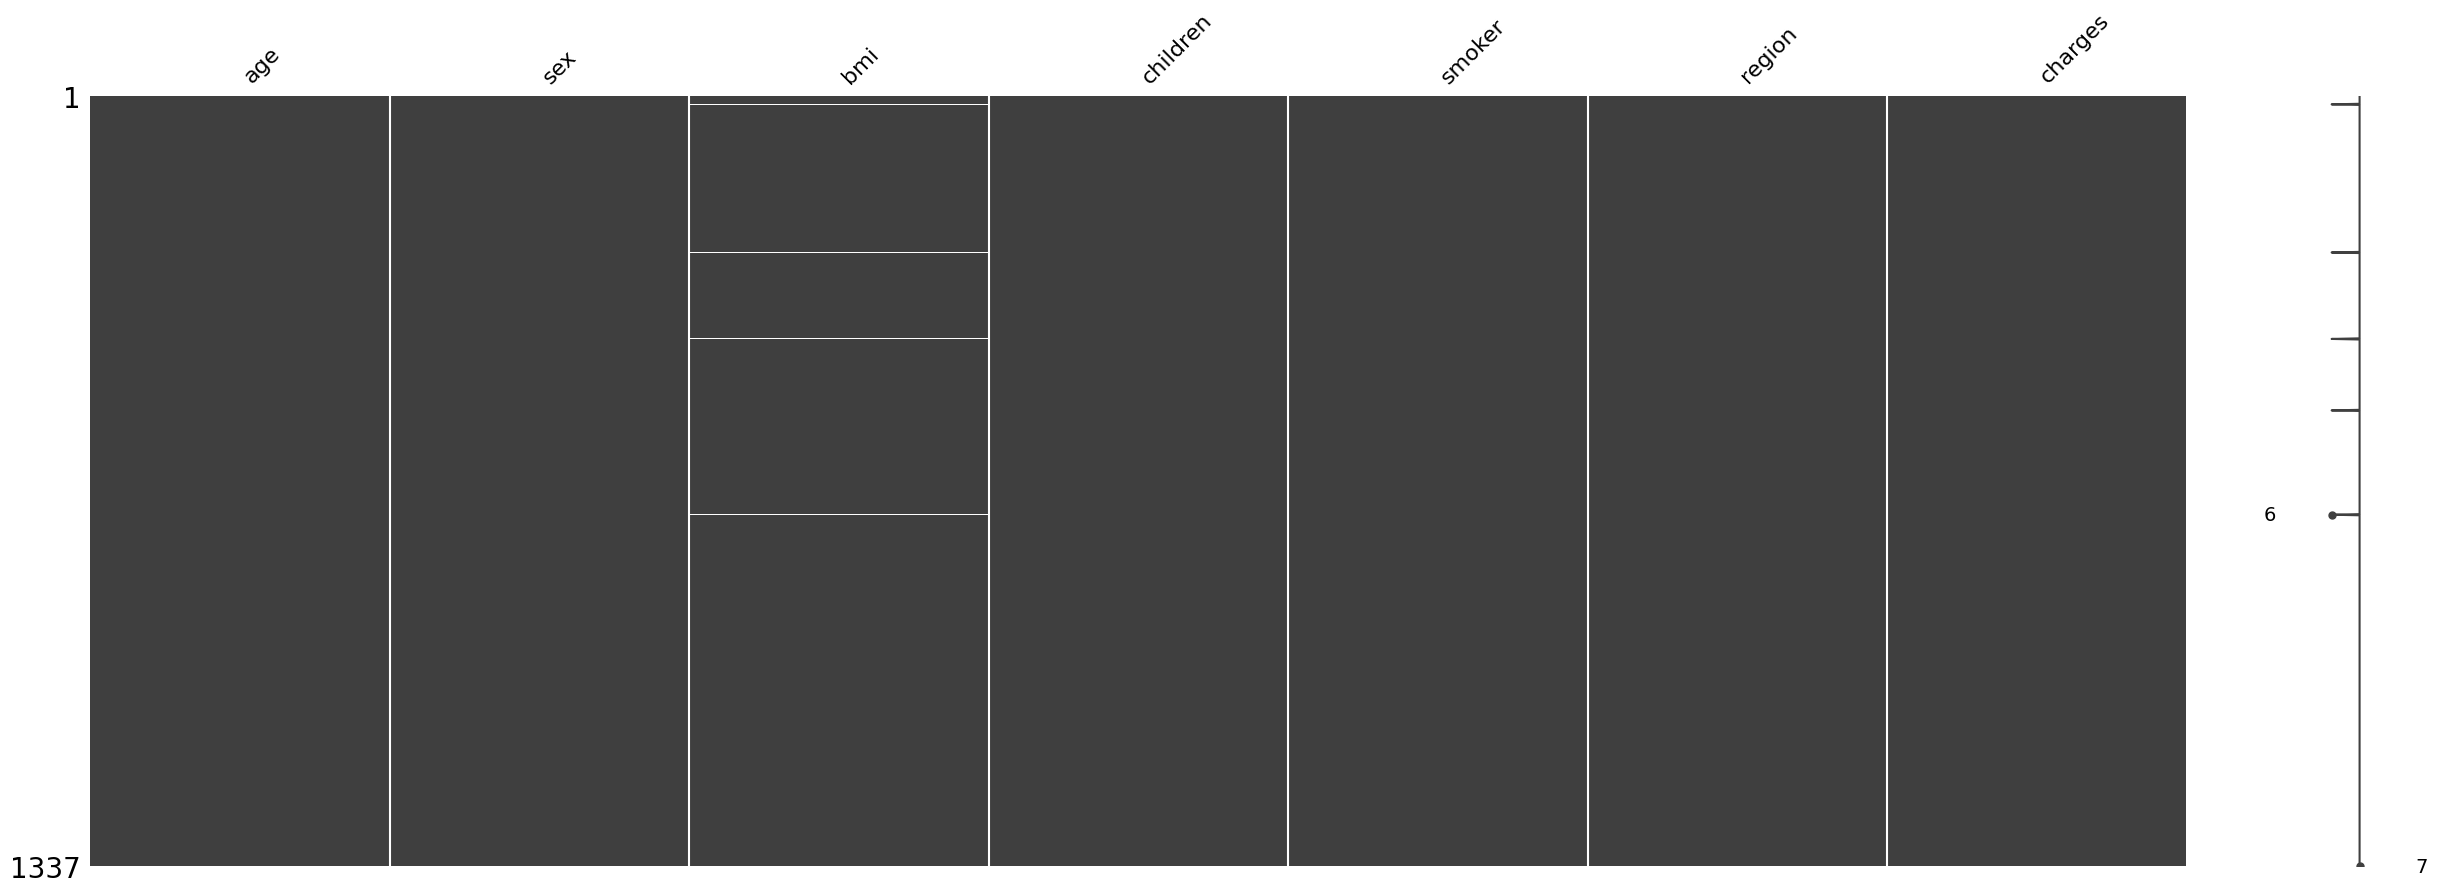

In [ ]:
 # 각 컬럼들에 몇 개의 NULL 값이 포함되어 있는지 확인
count_na = data.isnull().sum()
print(count_na[count_na > 0])

# missingno 패키지를 통해 시각화 확인
missingno.matrix(data, figsize=(30,10))

<Axes: >

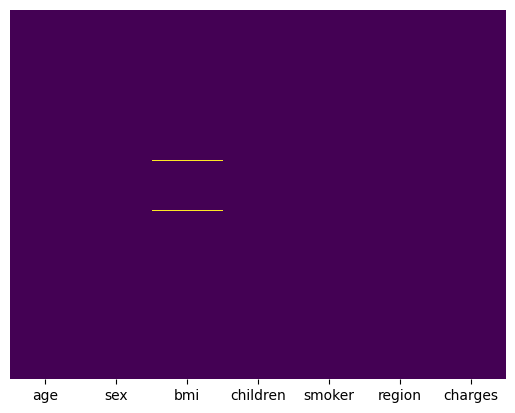

In [ ]:
# seaborn 패키지 heatmap 을 통해 시각화 확인
sns.heatmap(data.isnull(), cbar=False, yticklabels=False, cmap='viridis')

<Axes: >

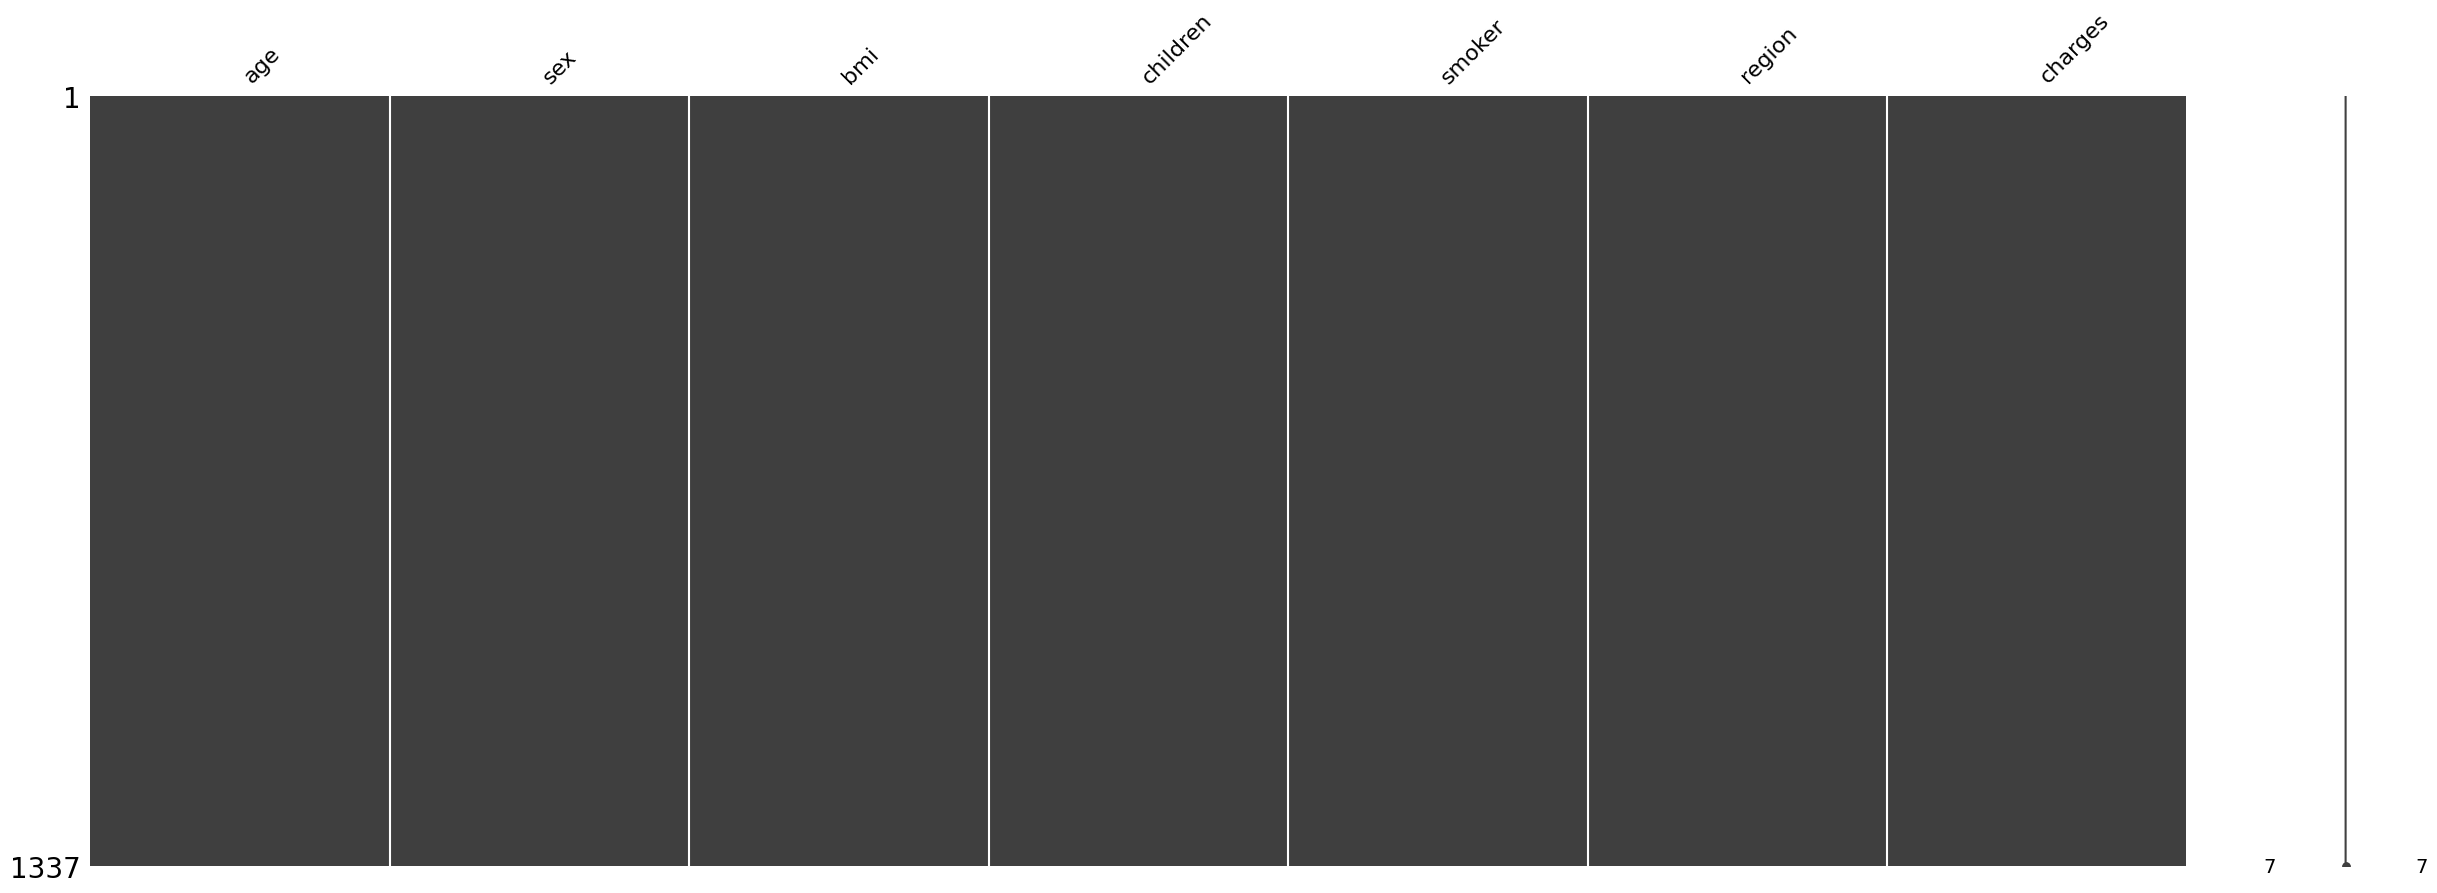

In [ ]:
# NULL 값을 해당 컬럼의 평균값으로 대체하기
data['bmi'].fillna(data['bmi'].mean(), inplace = True)
#print(data.head(15))

#확인
count_na = data.isnull().sum()
#print(count_na[count_na > 0])

# missingno 패키지를 통해 시각화 재확인
missingno.matrix(data, figsize=(30,10))

### 이상치 확인

In [ ]:
# 데이터 컬럼별 요약 통계값 보기
display(data.describe().T)

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.0000,27.000,39.0000,51.00000,64.00000
bmi,1337.0,30.658596,6.083657,15.9600,26.315,30.4000,34.60000,53.13000
children,1337.0,1.095737,1.205571,0.0000,0.000,1.0000,2.00000,5.00000
charges,1337.0,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


Axes(0.125,0.11;0.775x0.77)


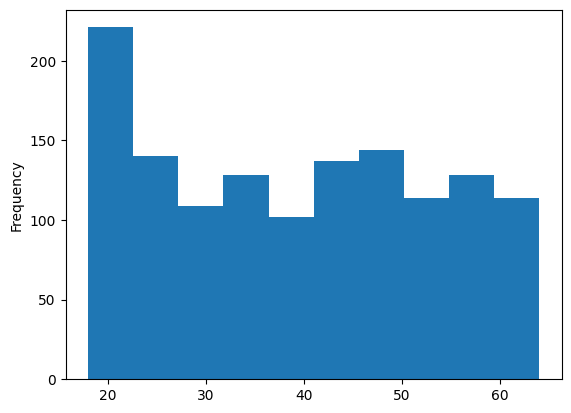

In [ ]:
# 데이터 개별 컬럼 히스토그램으로 확인하기
print(data.age.plot.hist())


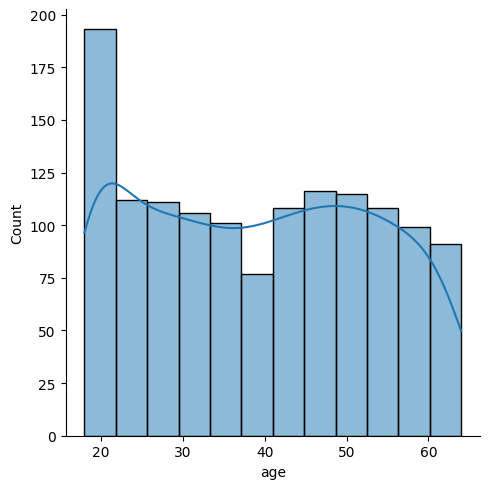

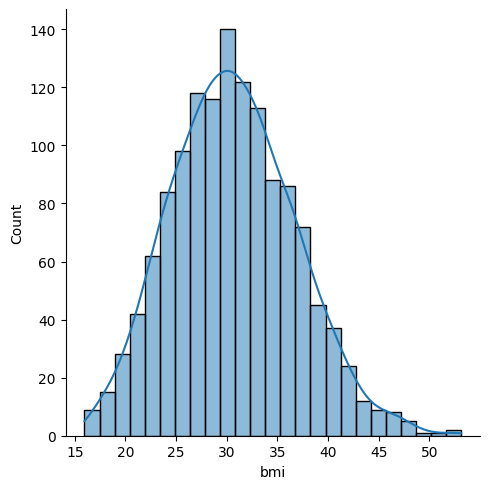

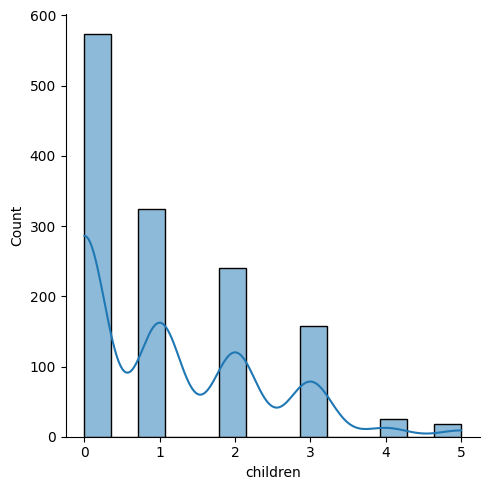

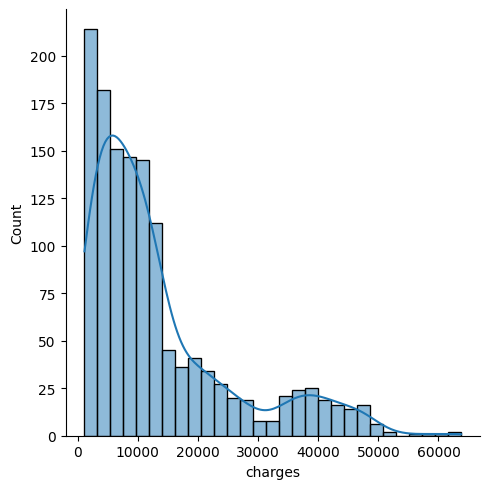

In [ ]:
# 숫자형 데이터 Skewness 확인
# 데이터 컬럼 타입이 np.number 인 것만 가져오기
numeric_data = data.select_dtypes(include=np.number)

# 데이터 컬럼 타입이 np.number 인 컬럼 이름들 가져오기
l = numeric_data.columns.values
number_of_columns = 4
number_of_rows = len(l)-1/number_of_columns

# 컬럼별 히스토그램 그리기
for i in range(0,len(l)):
  sns.displot(numeric_data[l[i]], kde=True)


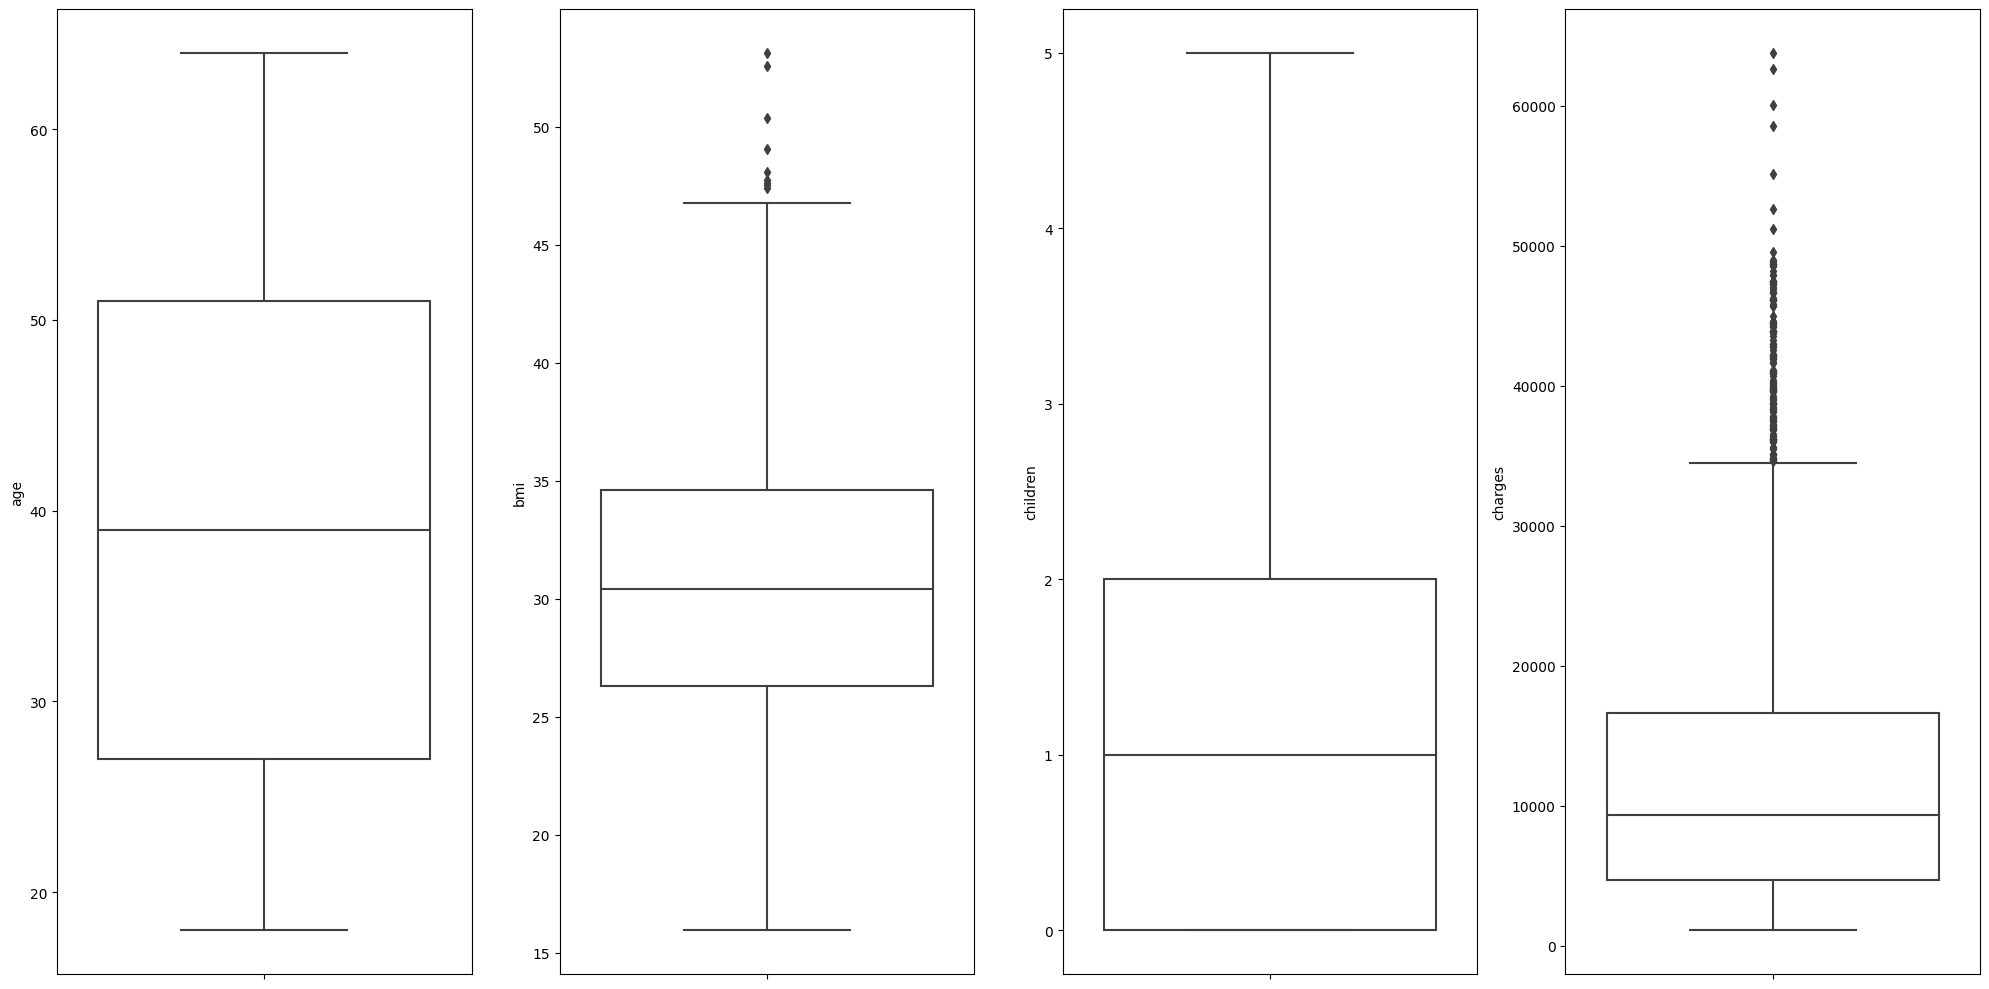

In [ ]:
# 데이터 컬럼 타입이 np.number 인 컬럼들 가져오기
columns = data.select_dtypes(include=np.number).columns
figure = plt.figure(figsize=(20, 10))
figure.add_subplot(1, len(columns), 1)
for index, col in enumerate(columns):
    if index > 0:
        figure.add_subplot(1, len(columns), index + 1)
    sns.boxplot(y=col, data=data, boxprops={'facecolor': 'None'})
figure.tight_layout() # 자동으로 명시된 여백에 관련된 서브플롯 파라미터를 조정한다.
plt.show()

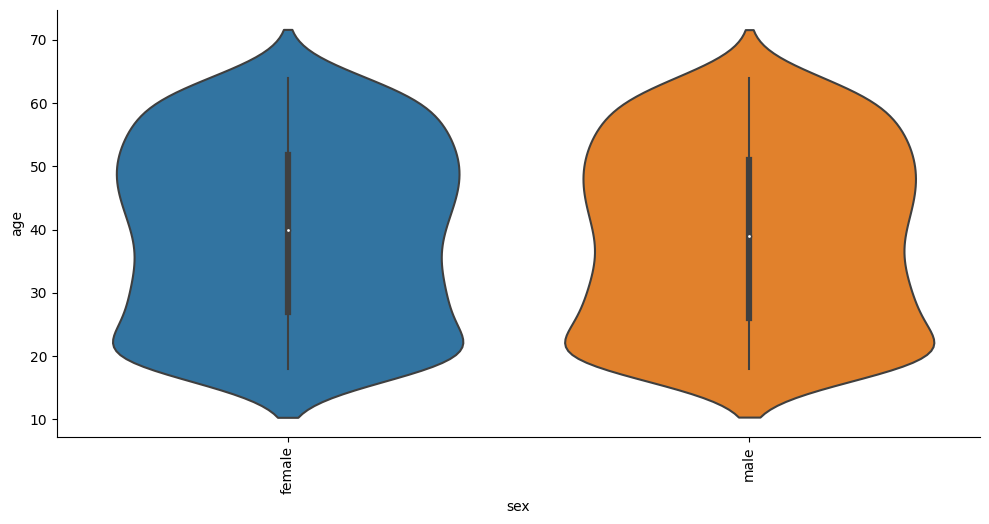

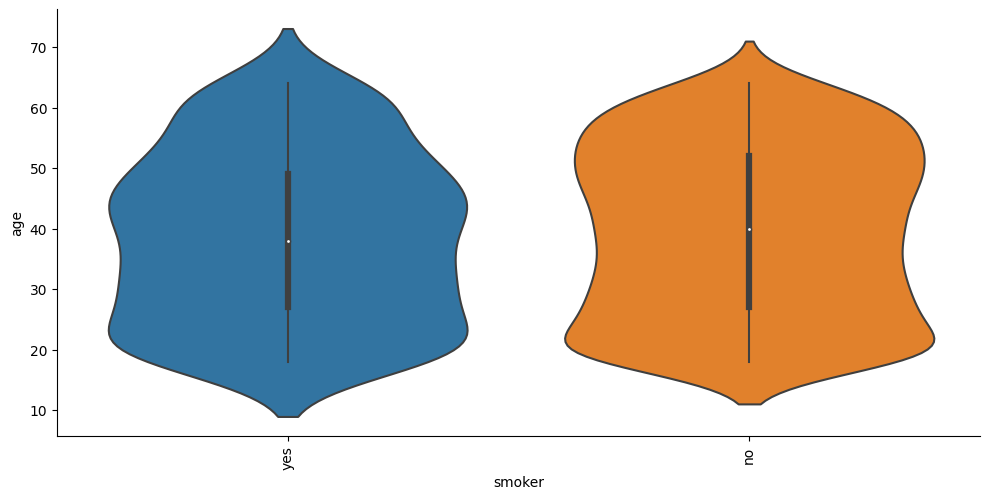

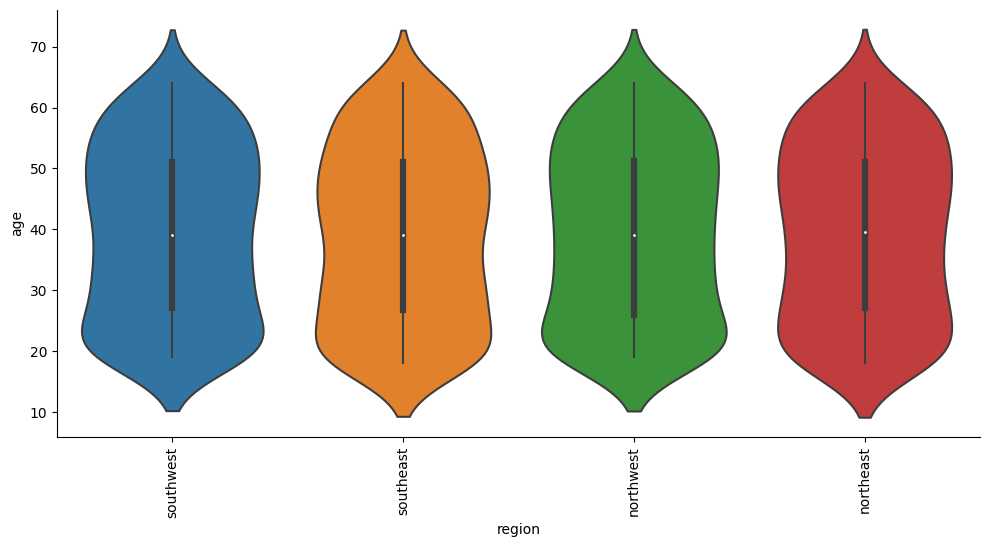

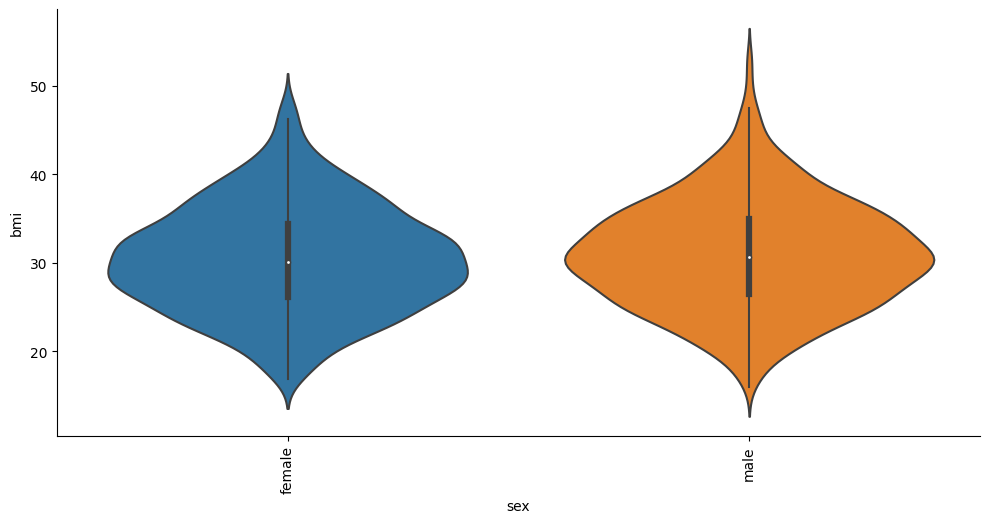

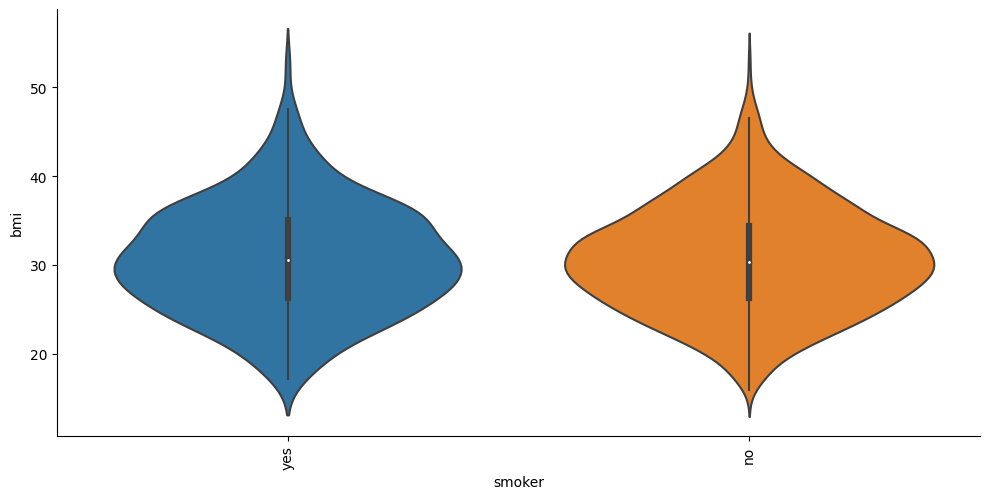

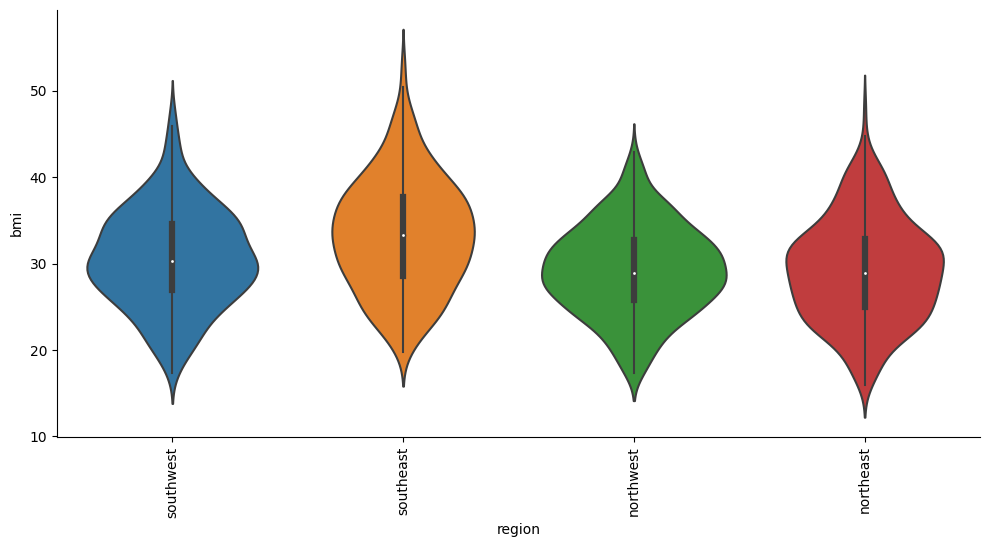

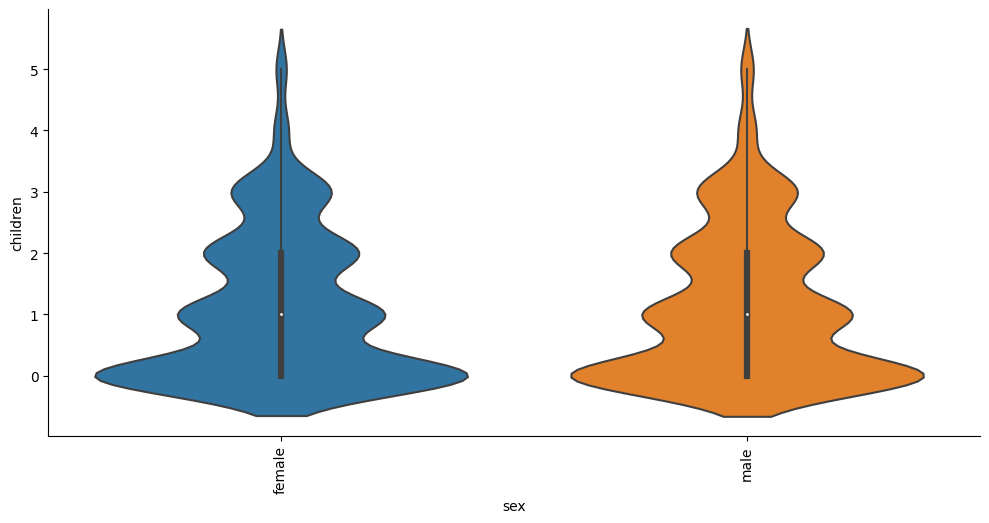

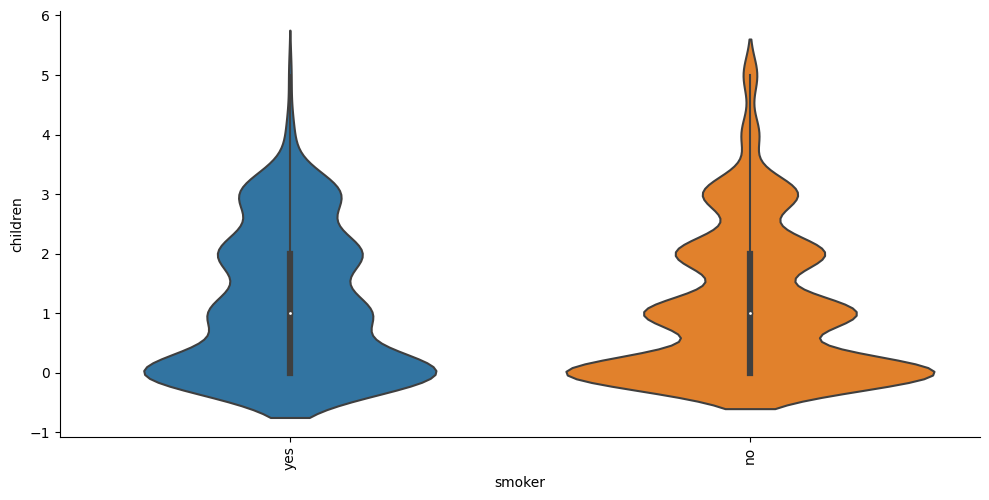

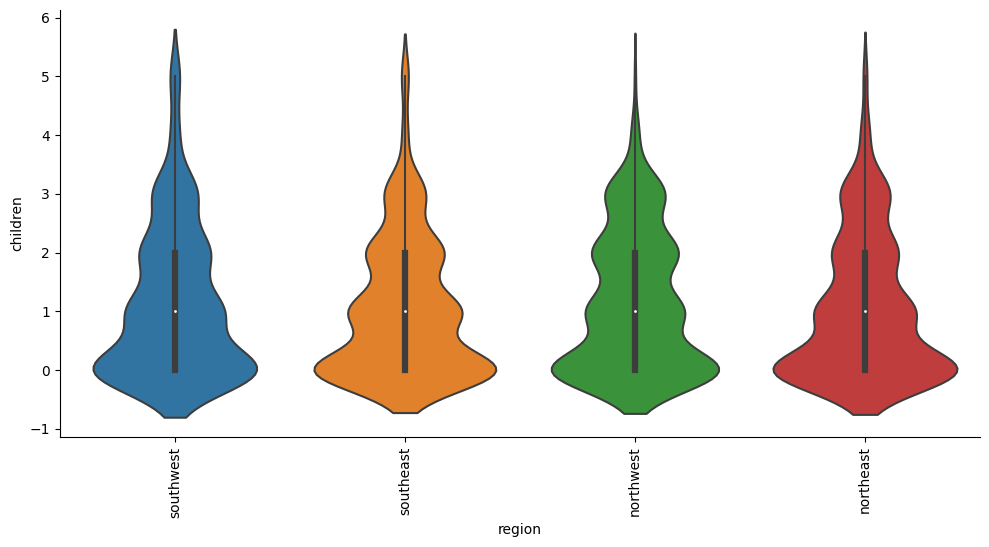

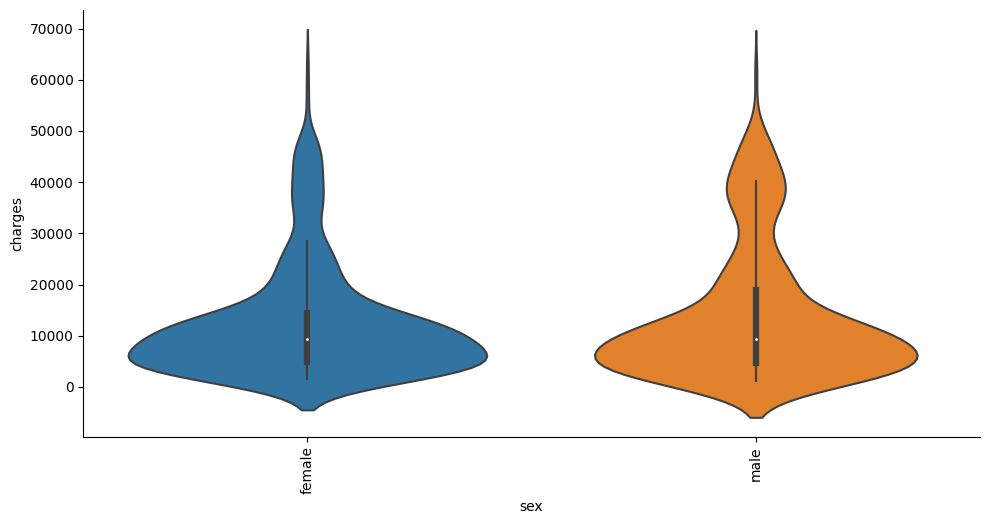

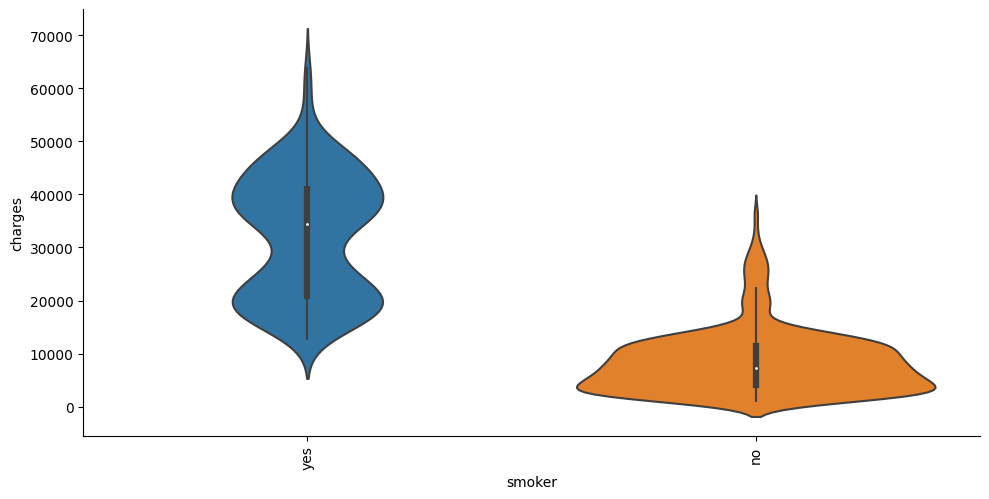

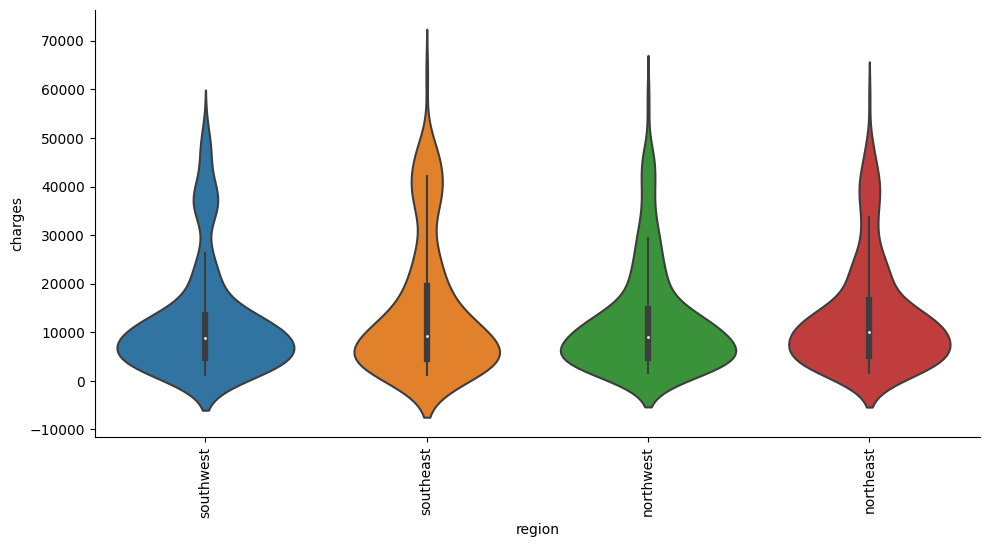

In [ ]:
# 범주형 데이터별 Violin Plot 시각화
if len(data.select_dtypes(include=['object','category']).columns) > 0:
        for col_num in data.select_dtypes(include=np.number).columns:
            for col in data.select_dtypes(include=['object','category']).columns:
                fig = sns.catplot(x=col, y=col_num, kind='violin', data=data, height=5, aspect=2)
                fig.set_xticklabels(rotation=90)
                plt.show()

### 변수간 상관성 확인

<ipython-input-25-5d4fb1ec2d8d>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), cmap='Blues', annot=False)


<Axes: >

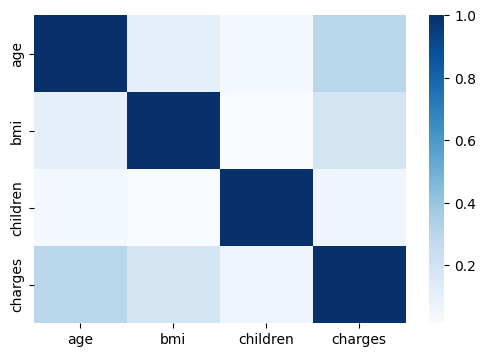

In [ ]:
# Seaborn Heatmap 을 사용한 Correlation 시각화
plt.figure(figsize=(6,4))
sns.heatmap(data.corr(), cmap='Blues', annot=False)

<ipython-input-26-96aaccc3c558>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cols = data.corr().nlargest(k, 'charges')['charges'].index


<Axes: >

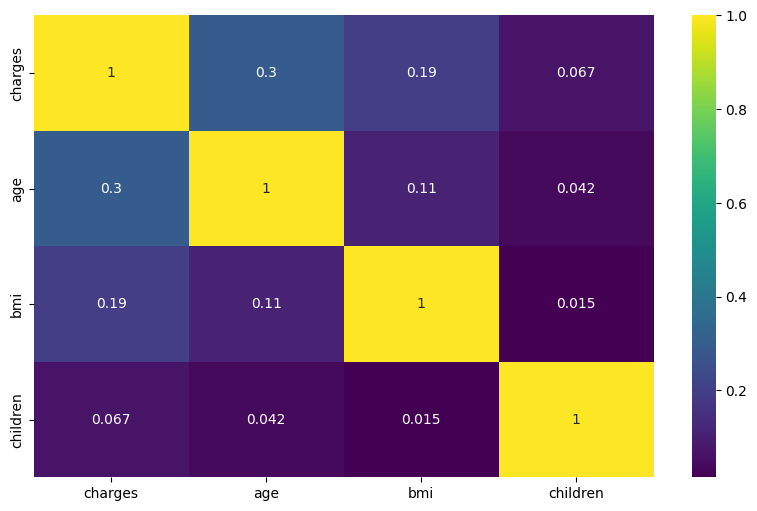

In [ ]:
# 보험료 Correlation Matrix 시각화
k = 4 # Heatmap 에서 확인한 변수 개수
cols = data.corr().nlargest(k, 'charges')['charges'].index
cm = data[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')

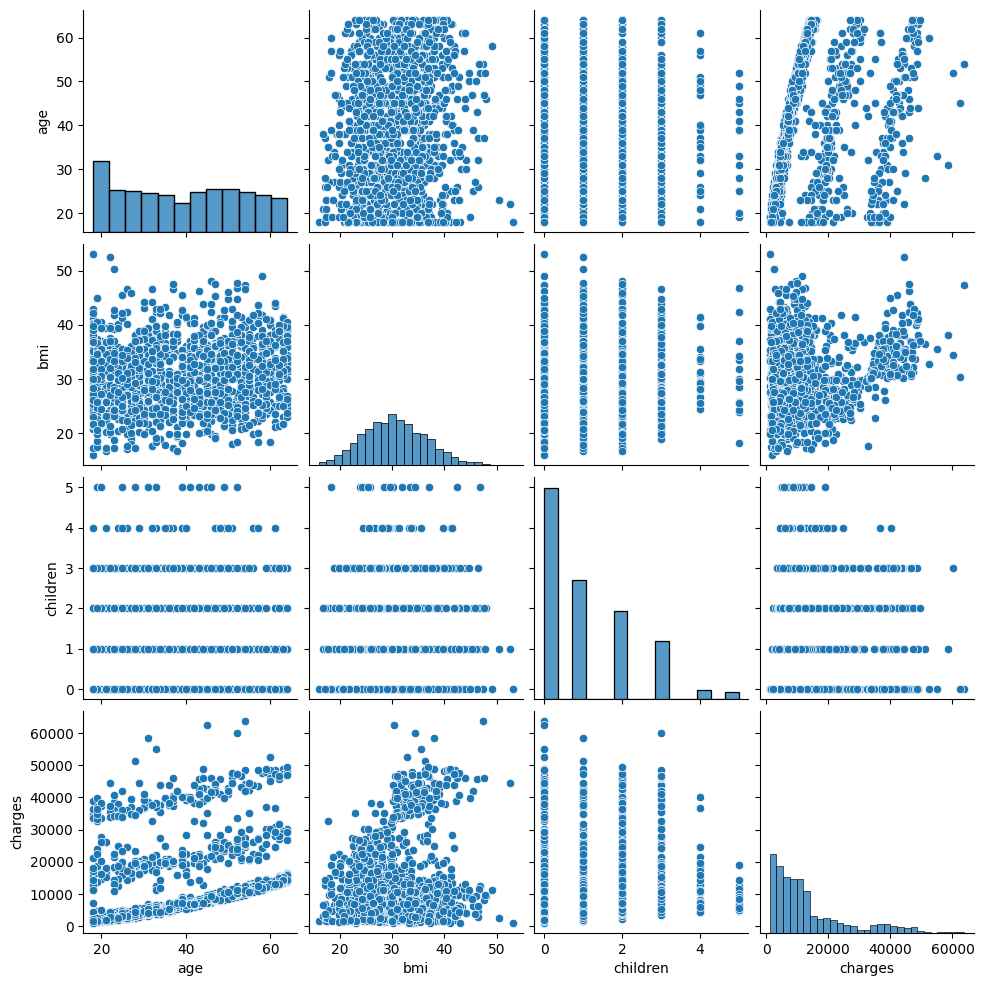

In [ ]:
# 숫자 변수형 컬럼들 간 Pairplot 그리기
sns.pairplot(data.select_dtypes(include=np.number))
plt.show()

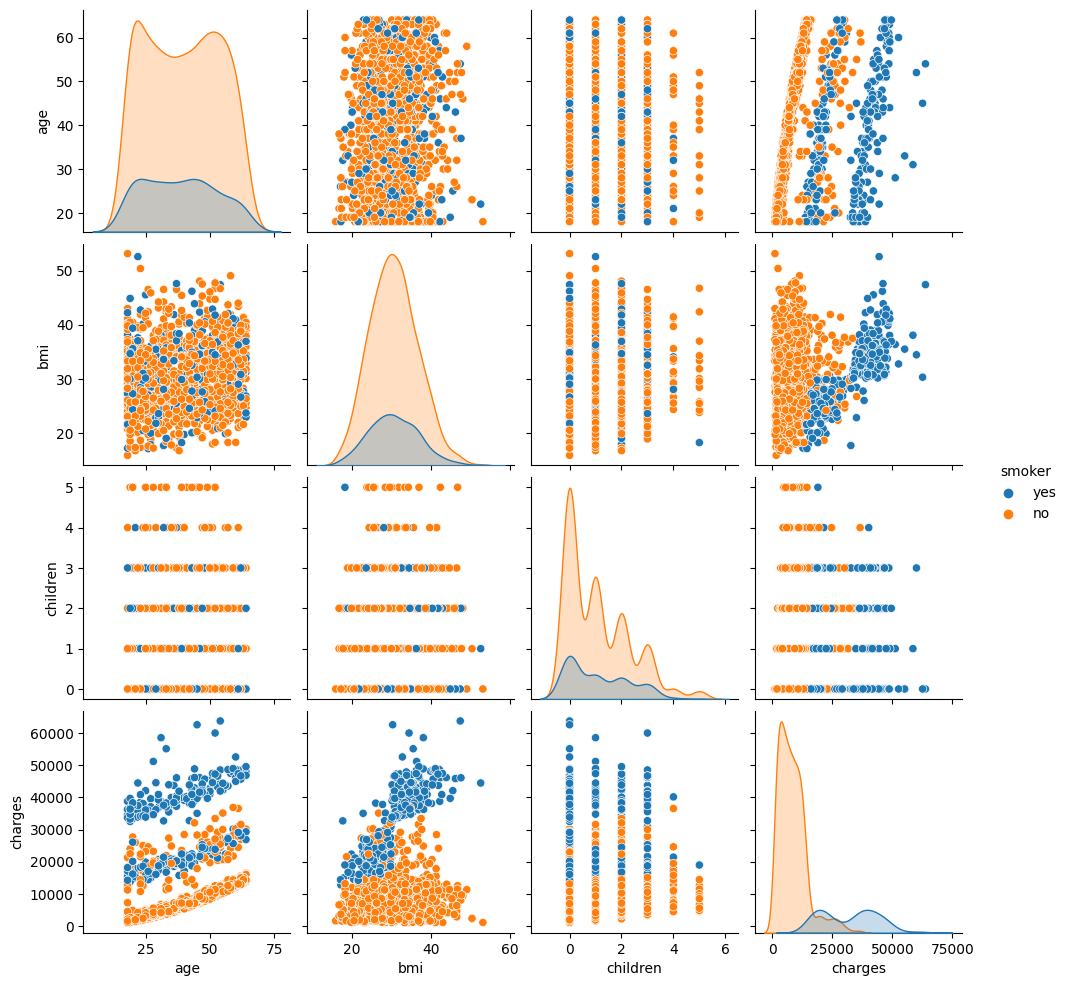

In [ ]:
# 범주형 데이터를 기준으로 추가한 시각화
# 위의 바이올린차트에서 흡연(범주형)이 보험료(숫자형)에 영향을 주는 것으로 보임
hue = 'smoker' # 흡연의 여부에 색을 넣어줌
sns.pairplot(data.select_dtypes(include=np.number).join(data[[hue]]), hue=hue)
plt.show()


# https://seaborn.pydata.org/examples/index.html

## Regression을 활용한 보험료 예측

**Training, Test 데이터 나누기**

In [ ]:
# 숫자형 데이터들만 copy() 를 사용하여 복사
X_num = data[['age', 'bmi', 'children']].copy()

# 변환했던 범주형 데이터들과 concat 을 사용하여 합치기
X_final = pd.concat([X_num, region, sex, smoker], axis = 1)

# 보험료 컬럼(charges)을 y 값으로 설정
y_final = data[['charges']].copy()

# train_test_split 을 사용하여 Training, Test 나누기 (Training:Test=2:1)
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=0)

In [ ]:
X_train[0:10]

,age,bmi,children,northeast,northwest,southeast,southwest,sex,smoker
905,27,32.585,3,1.0,0.0,0.0,0.0,1,0
2,28,33.000,3,0.0,0.0,1.0,0.0,1,0
405,52,38.380,2,1.0,0.0,0.0,0.0,0,0
481,49,37.510,2,0.0,0.0,1.0,0.0,1,0
338,50,32.300,1,1.0,0.0,0.0,0.0,1,1
356,46,43.890,3,0.0,0.0,1.0,0.0,1,0
1258,52,23.180,0,1.0,0.0,0.0,0.0,0,0
182,22,19.950,3,1.0,0.0,0.0,0.0,1,0
461,42,30.000,0,0.0,0.0,0.0,1.0,1,1
1058,32,33.820,1,0.0,1.0,0.0,0.0,1,0


In [ ]:
X_test[0:10]

,age,bmi,children,northeast,northwest,southeast,southwest,sex,smoker
1247,18,39.820,0,0.0,0.0,1.0,0.0,0,0
609,47,29.370,1,0.0,0.0,1.0,0.0,0,0
393,49,31.350,1,1.0,0.0,0.0,0.0,1,0
503,19,30.250,0,0.0,0.0,1.0,0.0,1,1
198,51,18.050,0,0.0,1.0,0.0,0.0,0,0
820,26,17.670,0,0.0,1.0,0.0,0.0,1,0
31,18,26.315,0,1.0,0.0,0.0,0.0,0,0
1250,19,19.800,0,0.0,0.0,0.0,1.0,1,0
1298,19,25.745,1,0.0,1.0,0.0,0.0,0,0
1150,58,36.480,0,0.0,1.0,0.0,0.0,0,0


### **Feature Scaling**

*   다차원의 값들을 비교 분석하기 쉽게 만든다.
*   변수들 간의 단위 차이가 있을 경우 필요하다.
*   Overflow, Underflow 를 방지해준다.


In [ ]:
## MinMaxScaler 를 사용하는 경우 :\
# 이상치가 있는 경우 변환된 값이 매우 좁은 범위로 압축될 수 있다

#n_scaler = MinMaxScaler()
#X_train = n_scaler.fit_transform(X_train.astype(np.float))
#X_test= n_scaler.transform(X_test.astype(np.float))

## StandardScaler 를 사용하는 경우 
#이상치가 있는 경우에는 균형 잡힌 결과를 보장하기 힘들다
# 이번 데이터에서는 특별한 이상치들이 없었으므로 StandardScaler를 사용함

s_scaler = StandardScaler()
X_train = s_scaler.fit_transform(X_train.astype(np.float))
X_test= s_scaler.transform(X_test.astype(np.float))

## 그 외 - RobustScaler 를 사용하는 경우 : 이상치의 영향을 최소화한 기법. 중앙값과 IQR 을 사용하기 때문에 표준화 후 동일한 값을 더 넓게 분포시키게 된다.


<ipython-input-34-025f7fe8cb71>:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train = s_scaler.fit_transform(X_train.astype(np.float))
<ipython-input-34-025f7fe8cb71>:13: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test= s_scaler.transform(X_test.astype(np.float))


**Regression 절차 요약**
*   fit()
*   predict()
*   score()


### Linear Regression 적용

In [ ]:
# fit model
lr = LinearRegression().fit(X_train, y_train)

In [ ]:
# predict
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

In [ ]:
# Score 확인
print("lr.coef_: {}".format(lr.coef_))
print("lr.intercept_: {}".format(lr.intercept_))
print('lr train score %.3f, lr test score: %.3f' % (
lr.score(X_train,y_train),
lr.score(X_test, y_test)))

# LinearRegression()은 1에 가까울 수록 직선에 가깝고,
# 0에 가까울 수록 직선의 경향이 없는 것


lr.coef_: [[3366.47112808 1725.71174012  603.99554217  268.25231121   14.31590009
   -13.39447522 -261.68008702  -71.08965939 9503.10176814]]
lr.intercept_: [13098.07379314]
lr train score 0.743, lr test score: 0.758


### Polynomial Regression 적용

In [ ]:
poly = PolynomialFeatures(degree = 3)
X_poly = poly.fit_transform(X_final)

X_train,X_test,y_train,y_test = train_test_split(X_poly,y_final, test_size = 0.33, random_state = 0)

In [ ]:
# Standard Scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train.astype(np.float))
X_test= sc.transform(X_test.astype(np.float))

<ipython-input-39-040bea98d8f5>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train = sc.fit_transform(X_train.astype(np.float))
<ipython-input-39-040bea98d8f5>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test= sc.transform(X_test.astype(np.float))


In [ ]:
# fit model
poly_lr = LinearRegression().fit(X_train,y_train)

In [ ]:
# predict
y_train_pred = poly_lr.predict(X_train)
y_test_pred = poly_lr.predict(X_test)

In [ ]:
# Score 확인
print('poly train score %.3f, poly test score: %.3f' % (
poly_lr.score(X_train,y_train),
poly_lr.score(X_test, y_test)))

# score 가 앞의 Linear Regression 보다 높음

poly train score 0.823, poly test score: 0.816


### Support Vector Regression 적용

In [ ]:
svr = SVR(kernel='linear', C = 300)

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.33, random_state = 0 )

In [ ]:
# Standard Scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train.astype(np.float))
X_test= sc.transform(X_test.astype(np.float))

<ipython-input-45-040bea98d8f5>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train = sc.fit_transform(X_train.astype(np.float))
<ipython-input-45-040bea98d8f5>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test= sc.transform(X_test.astype(np.float))


In [ ]:
# fit model
svr = svr.fit(X_train,y_train.values.ravel())
y_train_pred = svr.predict(X_train)
y_test_pred = svr.predict(X_test)

In [ ]:
# Score 확인
print('svr train score %.3f, svr test score: %.3f' % (
        svr.score(X_train,y_train),
        svr.score(X_test, y_test)))

svr train score 0.715, svr test score: 0.718


### RandomForest Regression 적용

In [ ]:
forest = RandomForestRegressor(n_estimators = 100, 
                               criterion = 'friedman_mse', 
                               random_state = 1, 
                               n_jobs = -1)

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.33, random_state = 0 )

In [ ]:
# Standard Scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train.astype(np.float))
X_test= sc.transform(X_test.astype(np.float))


<ipython-input-67-040bea98d8f5>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train = sc.fit_transform(X_train.astype(np.float))
<ipython-input-67-040bea98d8f5>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test= sc.transform(X_test.astype(np.float))


In [ ]:
# fit model
forest.fit(X_train,y_train.values.ravel())
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

In [ ]:
# Score 확인
print('forest train score %.3f, forest test score: %.3f' % (
forest.score(X_train, y_train),
forest.score(X_test, y_test)))

forest train score 0.975, forest test score: 0.843


### Decision Tree Regression 적용

In [ ]:
dt = DecisionTreeRegressor(random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.33, random_state = 0 )

In [ ]:
# Standard Scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train.astype(np.float))
X_test= sc.transform(X_test.astype(np.float))

<ipython-input-71-040bea98d8f5>:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train = sc.fit_transform(X_train.astype(np.float))
<ipython-input-71-040bea98d8f5>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_test= sc.transform(X_test.astype(np.float))


In [ ]:
# fit model
dt = dt.fit(X_train,y_train.values.ravel())
y_train_pred = dt.predict(X_train)
y_test_pred = dt.predict(X_test)

In [ ]:
# Score 확인
print('dt train score %.3f, dt test score: %.3f' % (
dt.score(X_train,y_train),
dt.score(X_test, y_test)))

dt train score 0.999, dt test score: 0.701


## 사용한 모델 종합 비교

In [ ]:
# 앞에서 만든 regressor 변수들과 라벨을 묶어서 하나의 리스트로 모으기
regressors = [(lr, 'Linear Regression'),
                (poly_lr, 'Polynomial Regression'),
                (svr, 'SupportVector Regression'),
                (forest, 'RandomForest Regression'),
                (dt, 'DecisionTree')]

# 각 regressor 변수들과 라벨 묶음을 차례로 fit -> predict -> score 로 처리해서 보여주기
for reg, label in regressors:
    print(80*'_', '\n')
    reg = reg.fit(X_train,y_train.values.ravel())
    y_train_pred = reg.predict(X_train)
    y_test_pred = reg.predict(X_test)
    print(f'{label} train score %.3f, {label} test score: %.3f' % (
    reg.score(X_train,y_train),
    reg.score(X_test, y_test)))


________________________________________________________________________________ 

Linear Regression train score 0.743, Linear Regression test score: 0.758
________________________________________________________________________________ 

Polynomial Regression train score 0.743, Polynomial Regression test score: 0.758
________________________________________________________________________________ 

SupportVector Regression train score 0.715, SupportVector Regression test score: 0.718
________________________________________________________________________________ 

RandomForest Regression train score 0.975, RandomForest Regression test score: 0.843
________________________________________________________________________________ 

DecisionTree train score 0.999, DecisionTree test score: 0.701


결과 해석 > RandomForest Regression 이 train도 높고, test도 가장 높았다, 이 데이터에서는 RandomForest Regression 모델을 사용할 것